In [42]:
%matplotlib notebook

import arcpy
import os
import sys
import numpy as np
import scipy.ndimage as nd
import matplotlib.pyplot as plt
import fiona as f
import scipy
import statsmodels

import geopandas as gp
import mplleaflet
from shapely.geometry import box as shape_box
# from shapely.geometry import Polygon
# import dbf2df as dbf
import gdal
gdal.UseExceptions()
import ogr
import osr
# import pickle
import pandas as pd
# from model_specs import *
# pth = 'MFGrid/mfgrid'
# sys.path.append(pth)
# import grid
from IPython.display import Image
from IPython.display import Math

from __future__ import print_function
import statsmodels.api as sm

from sklearn import linear_model

pd.set_option('display.height', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

from arcpy import env

height has been deprecated.



In [43]:
# Set environment settings
env.workspace = r"C:\Local_GIS\Vienna\Tree_soil_correlation"

In [13]:
##Import soil data
#soil_file = r'C:\Local_GIS\Vienna\Tree_soil_correlation\All_samples_StatePlane.shp'
#soil_s = gp.read_file(soil_file)

In [14]:
# #Import soil data
# trees_ft = all_trees.to_crs(soil.crs)

In [15]:
trees = r'U:\MST\Vienna\GIS\All_trees_summarized.shp'

inFeatures = "All_trees_summarized"
fieldName1 = "buffer_fie"
fieldPrecision = 9
fieldLength = 10
 
# Execute AddField twice for two new fields
arcpy.AddField_management(inFeatures, fieldName1, "DOUBLE", fieldPrecision,
                          field_is_nullable="NULLABLE")

In [44]:
maxbuffer=50

In [ ]:
for x in range(1,maxbuffer):
    arcpy.CopyFeatures_management("All_trees_summarized_ft","All_trees_summarized_ft_{}x".format(x))

In [16]:
for x in range(1,maxbuffer):
    arcpy.CalculateField_management("All_trees_summarized_ft_{}x".format(x),"buffer_fie",'!Average_Tr!*{}/12'.format(x),'PYTHON_9.3')
# arcpy.CalculateField_management("All_trees_summarized_ft_20x","buffer_field",'!Average_Tr!*20/12','PYTHON_9.3')
# arcpy.CalculateField_management("All_trees_summarized_ft_40x","buffer_field",'!Average_Tr!*40/12','PYTHON_9.3')

### Selecting and creating shapefiles for the desired depth intervals of soil samples from 0 to 17 ft

In [17]:
if arcpy.Exists("lyr"):
    arcpy.Delete_management("lyr")
for s in range(1,maxbuffer):
    for i in range(0,18,1):
        for x in range(i+1,19,1):
            arcpy.MakeFeatureLayer_management(soil_file, "lyr")
            arcpy.SelectLayerByAttribute_management("lyr", "ADD_TO_SELECTION", '"Depth_bott" <={} and "Depth_top" >={}'.format(x,i))
            arcpy.CopyFeatures_management("lyr", "soil_{}to{}ft_{}x".format(i,x,s))

            if arcpy.Exists("lyr"):
                arcpy.Delete_management("lyr")

In [18]:
# Buffer areas of impact around major roads
if arcpy.Exists("All_trees_summarized_buffer.shp"):
    arcpy.Delete_management("All_trees_summarized_buffer.shp")
for x in range(1,maxbuffer):

    trees = "All_trees_summarized_ft_{}x.shp".format(x)
   
    distanceField = "buffer_fie"

    trees_buffer = r"All_trees_summarized_buffer_{}x.shp".format(x)

    arcpy.Buffer_analysis(trees, trees_buffer, buffer_distance_or_field=distanceField)


# trees = "All_trees_summarized_ft.shp"
# trees_10x = "All_trees_summarized_ft_10x.shp"
# trees_20x = "All_trees_summarized_ft_20x.shp"
# trees_40x = "All_trees_summarized_ft_40x.shp"
# trees_buffer = r"All_trees_summarized_buffer.shp"
# distanceField = "buffer_fie"

# trees_buffer_10x = r"All_trees_summarized_buffer_10x.shp"
# trees_buffer_20x = r"All_trees_summarized_buffer_20x.shp"
# trees_buffer_40x = r"All_trees_summarized_buffer_40x.shp"

# # arcpy.Buffer_analysis(trees, trees_buffer, buffer_distance_or_field=distanceField)
# arcpy.Buffer_analysis(trees_10x, trees_buffer_10x, buffer_distance_or_field=distanceField)
# arcpy.Buffer_analysis(trees_20x, trees_buffer_20x, buffer_distance_or_field=distanceField)
# arcpy.Buffer_analysis(trees_40x, trees_buffer_40x, buffer_distance_or_field=distanceField)


In [19]:
for s in range(1,maxbuffer):
    for i in range(0,18,1):
        for x in range(i+1,19,1):
            soil=r"soil_{}to{}ft_{}x.shp".format(i,x,s)
            outfc = r"Tree_soil_matches_{}to{}ft_{}x.shp".format(i,x,s)

            trees_buffer = r"All_trees_summarized_buffer_{}x.shp".format(s)

            fieldmappings = arcpy.FieldMappings()
            fieldmappings.addTable(trees_buffer)
            fieldmappings.addTable(soil)
            PCEFieldIndex = fieldmappings.findFieldMapIndex("TETRACHLOR")
            TCEFieldIndex = fieldmappings.findFieldMapIndex("TRICHLOROE")
            CFCFieldIndex = fieldmappings.findFieldMapIndex("a112_Trich")
            fieldmap = fieldmappings.getFieldMap(PCEFieldIndex)
            fieldmap2 = fieldmappings.getFieldMap(TCEFieldIndex)
            fieldmap3 = fieldmappings.getFieldMap(CFCFieldIndex)

            # Get the output field's properties as a field object
            field = fieldmap.outputField
            field2 = fieldmap2.outputField
            field3 = fieldmap3.outputField

            # Rename the field and pass the updated field object back into the field map
            field.name = "mean_PCE_soil"
            field.aliasName = "mean_PCE_soil"
            fieldmap.outputField = field

            field2.name = "mean_TCE_soil"
            field2.aliasName = "mean_TCE_soil"
            fieldmap2.outputField = field2

            field3.name = "mean_CFC_soil"
            field3.aliasName = "mean_CFC_soil"
            fieldmap3.outputField = field3

            # Set the merge rule to mean and then replace the old fieldmap in the mappings object
            # with the updated one
            fieldmap.mergeRule = "mean"
            fieldmap2.mergeRule = "mean"
            fieldmap3.mergeRule = "mean"
            fieldmappings.replaceFieldMap(PCEFieldIndex, fieldmap)
            fieldmappings.replaceFieldMap(TCEFieldIndex, fieldmap2)
            fieldmappings.replaceFieldMap(CFCFieldIndex, fieldmap3)

            arcpy.SpatialJoin_analysis(trees_buffer, soil, outfc, "JOIN_ONE_TO_ONE", "KEEP_COMMON", fieldmappings, "CONTAINS")



## Single SLR

<IPython.core.display.Javascript object>


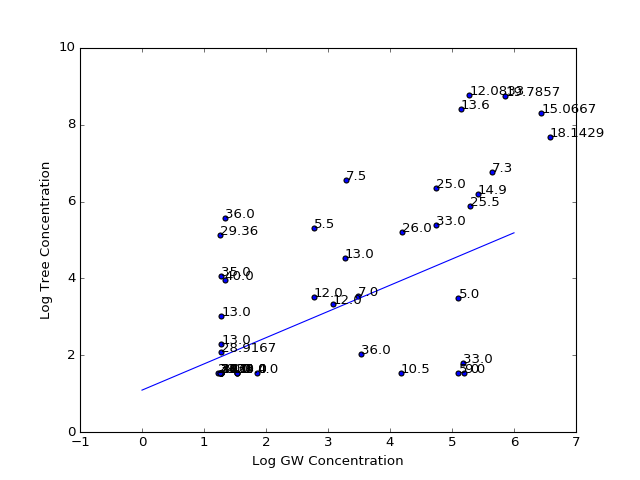

In [41]:
trees_soil_matched_file = 'C:\Local_GIS\Vienna\Tree_soil_correlation\Tree_soil_matches_6to7ft.shp'
matched = gp.read_file(trees_soil_matched_file)

# soil_file = 'C:\Local_GIS\Vienna\Tree_soil_correlation\soil_6to7ft.shp'
# soil = gp.read_file(soil_file)

matched.loc[matched['Average_PC']<=4.7,'Average_PC']=4.7
matched.loc[matched['mean_PCE_s']<=1,'mean_PCE_s']=np.nan
# trees_gw_pce.loc[trees_gw_pce['TETRACHL_2']=='U','TETRACHLOR']  = 2
matched['soil_log_pce'] = np.log(matched['mean_PCE_s'])
matched['tree_log_pce'] = np.log(matched['Average_PC'])


# matched.loc[matched['Average_TC']<=7.7,'Average_TC']=7.7
# # matched.loc[matched['TRICHLOR_2']=='U','TRICHLOROE']  = 2
# matched.loc[matched['mean_TCE_s']==1,'mean_TCE_s']  = np.nan
# matched['soil_log_tce'] = np.log(matched['mean_TCE_s'])
# matched['tree_log_tce'] = np.log(matched['Average_TC'])


# matched.loc[matched['Average_CF']==1,'Average_CF']=np.nan
# matched.loc[matched['mean_CFC_s']==1,'mean_CFC_s']  = np.nan
# matched['soil_log_cfc'] = np.log(matched['mean_CFC_s'])
# matched['tree_log_cfc'] = np.log(matched['Average_CF'])

# X1 = sm.add_constant(matched.tree_log_cfc)
# model_cfc = sm.OLS(matched.soil_log_cfc,X1, missing='drop')
# results_cfc = model_cfc.fit()

# print(results_cfc.summary())

# rho_cfc = scipy.stats.spearmanr(matched.soil_log_cfc, matched.tree_log_cfc, nan_policy='omit')
# print(rho_cfc.pvalue)



# X2 = sm.add_constant(matched.tree_log_tce)
# model_tce = sm.OLS(matched.soil_log_tce,X2, missing='drop')
# results_tce = model_tce.fit()

# print(results_tce.summary())

# rho_tce = scipy.stats.spearmanr(matched.soil_log_tce, matched.tree_log_tce, nan_policy='omit')


X3 = sm.add_constant(matched.soil_log_pce)
model_pce = sm.OLS(matched.tree_log_pce,X3, missing='drop')
results_pce = model_pce.fit()

# print(results_pce.summary())

# rho_pce = scipy.stats.spearmanr(matched.soil_log_pce, matched.tree_log_pce,nan_policy='omit')


# ax = soil.plot()
# matched.plot(ax=ax, cmap='Pastel1',alpha=0.01,linewidth=0.1)

# statsmodels.graphics.regressionplots.plot_regress_exog(results_pce,1)

fig, ax = plt.subplots()
ax.scatter(matched.soil_log_pce,matched.tree_log_pce)
for gw, tree, diam in zip(matched.soil_log_pce, matched.tree_log_pce, matched.Average_Tr):                                       # <--
    ax.annotate('{}'.format(diam),xy=(gw, tree))
plt.xlabel('Log GW Concentration')
plt.ylabel('Log Tree Concentration')
plt.plot([0,6],[results_pce.params[0],6*results_pce.params[1]])
    
plt.show()


# fig = plt.figure()

# ax1 = fig.add_subplot(211)
# plt.title('PCE')
# plt.ylabel('Log Tree')
# plt.xlabel('Log Soil')
# ax1.plot( matched.soil_log_pce,matched.tree_log_pce,linestyle='None', marker='o', markersize=2)
# # plt.axis('equal')
# plt.grid('on')
# plt.plot(range(10),'--')

# ax2 = fig.add_subplot(212)
# ax2.plot( results_pce.fittedvalues, results_pce.resid,linestyle='None', marker='o', markersize=2)
# # plt.axis('equal')
# plt.grid('on')
# plt.ylabel('Residual')
# plt.xlabel('Predicted')


# ax3 = fig.add_subplot(233)
# plt.title('TCE')
# plt.ylabel('Log GW')
# plt.xlabel('Log Tree')
# ax3.plot(trees_gw_tce.tree_log_tce, trees_gw_tce.soil_log_tce,linestyle='None', marker='o', markersize=2)
# plt.axis('equal')
# plt.grid('on')
# # plt.plot(range(10),'--')

# ax4 = fig.add_subplot(234)
# ax4.plot(results_tce.resid, results_tce.fittedvalues, linestyle='None', marker='o', markersize=2)
# plt.axis('equal')
# plt.grid('on')
# plt.ylabel('Predicated')
# plt.xlabel('Residual')



In [39]:
results_pce.params

const           3.305950
soil_log_pce    0.572737
dtype: float64

In [22]:
Indices=range(0,153,1)
j=0
for i in range(0,17,1):
    for x in range(i+1,18,1):
        Indices[j]='{}to{}ft'.format(i,x)
        j+=1

stats = pd.DataFrame(columns=['R2-PCE_1', 'c_1','p_1','n_1','R2-CFC_1','c_1', 'p_1','n_1','R2-TCE_1','c_1','p_1','n_1'],index=Indices)



## Looping the SLR 

In [23]:
j=1
for s in range(1.maxbuffer):
    for i in range(0,18,1):
        for x in range(i+1,19,1):
            trees_soil_matched = 'C:\Local_GIS\Vienna\Tree_soil_correlation\Tree_soil_matches_{}to{}ft_{}x.shp'.format(i,x,s)
            matched = gp.read_file(trees_soil_matched)

            matched.loc[matched['Average_PC']<=0.47,'Average_PC']=0.47
            matched.loc[matched['mean_PCE_s']<=0,'mean_PCE_s']=np.nan
            # trees_gw_pce.loc[trees_gw_pce['TETRACHL_1']=='U','TETRACHLOR']  = 1
            matched['soil_log_pce'] = np.log(matched['mean_PCE_s'])
            matched['tree_log_pce'] = np.log(matched['Average_PC'])


            matched.loc[matched['Average_TC']<=7.7,'Average_TC']=7.7
            # matched.loc[matched['TRICHLOR_1']=='U','TRICHLOROE']  = 1
            matched.loc[matched['mean_TCE_s']==0,'mean_TCE_s']  = np.nan
            matched['soil_log_tce'] = np.log(matched['mean_TCE_s'])
            matched['tree_log_tce'] = np.log(matched['Average_TC'])


            matched.loc[matched['Average_CF']==0,'Average_CF']=np.nan
            matched.loc[matched['mean_CFC_s']==0,'mean_CFC_s']  = np.nan
            matched['soil_log_cfc'] = np.log(matched['mean_CFC_s'])
            matched['tree_log_cfc'] = np.log(matched['Average_CF'])

            try:
                X = matched[['soil_log_cfc','Average_Tr']]
                X1 = sm.add_constant(X)
    #             X1 = sm.add_constant(matched.tree_log_cfc)
                model_cfc = sm.OLS(matched.tree_log_cfc,X1, missing='drop')
                results_cfc = model_cfc.fit()

                stats.iloc[j-1,6]=results_cfc.rsquared_adj
                stats.iloc[j-1,7]=results_cfc.pvalues.loc['const']
                stats.iloc[j-1,8]=results_cfc.pvalues.loc['tree_log_cfc']
                stats.iloc[j-1,9]=results_cfc.df_resid+2


            except ValueError:
                stats.iloc[j-1,6]=np.nan
                stats.iloc[j-1,7]=np.nan
                stats.iloc[j-1,8]=np.nan
                stats.iloc[j-1,9]=np.nan

            try:
                rho_cfc = scipy.stats.spearmanr(matched.soil_log_cfc, matched.tree_log_cfc,nan_policy="omit")
                stats.iloc[j-1,10]=rho_cfc.correlation
                stats.iloc[j-1,11]=rho_cfc.pvalue

            except ValueError:
                stats.iloc[j-1,10]=np.nan
                stats.iloc[j-1,11]=np.nan


            try:
                X = matched[['soil_log_tce','Average_Tr']]
                X2 = sm.add_constant(X)
    #             X2 = sm.add_constant(matched.tree_log_tce)
                model_tce = sm.OLS(matched.tree_log_tce,X2, missing='drop')
                results_tce = model_tce.fit()

                stats.iloc[j-1,12]=results_tce.rsquared_adj
                stats.iloc[j-1,13]=results_tce.pvalues.loc['const']
                stats.iloc[j-1,14]=results_tce.pvalues.loc['tree_log_tce']
                stats.iloc[j-1,15]=results_tce.df_resid+2

            except ValueError:
                stats.iloc[j-1,12]=np.nan
                stats.iloc[j-1,13]=np.nan
                stats.iloc[j-1,14]=np.nan
                stats.iloc[j-1,15]=np.nan


            try:
                rho_tce = scipy.stats.spearmanr(matched.soil_log_tce, matched.tree_log_tce,nan_policy="omit")
                stats.iloc[j-1,16]=rho_tce.correlation
                stats.iloc[j-1,17]=rho_tce.pvalue

            except ValueError:
                stats.iloc[j-1,16]=np.nan
                stats.iloc[j-1,17]=np.nan


            try:
                X = matched[['soil_log_pce','Average_Tr']]
                X3 = sm.add_constant(X)
    #             X3 = sm.add_constant(matched.tree_log_pce)
                model_pce = sm.OLS(matched.tree_log_pce,X3, missing='drop')
                results_pce = model_pce.fit()

                stats.iloc[j-1,0]=results_pce.rsquared_adj
                stats.iloc[j-1,1]=results_pce.pvalues.loc['const']
                stats.iloc[j-1,2]=results_pce.pvalues.loc['tree_log_pce']
                stats.iloc[j-1,3]=results_pce.df_resid+2

            except ValueError:
                stats.iloc[j-1,0]=np.nan
                stats.iloc[j-1,1]=np.nan
                stats.iloc[j-1,2]=np.nan
                stats.iloc[j-1,3]=np.nan           



            try:
                rho_pce = scipy.stats.spearmanr(matched.soil_log_pce, matched.tree_log_pce,nan_policy="omit")
                stats.iloc[j-1,4]=rho_pce.correlation
                stats.iloc[j-1,5]=rho_pce.pvalue

            except ValueError:
                stats.iloc[j-1,4]=np.nan
                stats.iloc[j-1,5]=np.nan      

    #         stats.iloc[j-1,0]=results_pce.rsquared_adj
    #         stats.iloc[j-1,1]=results_pce.pvalues.loc['const']
    #         stats.iloc[j-1,2]=results_pce.pvalues.loc['tree_log_pce']
    #         stats.iloc[j-1,3]=results_pce.df_resid+2
    #         stats.iloc[j-1,4]=rho_pce.correlation
    #         stats.iloc[j-1,5]=rho_pce.pvalue.data
    #         stats.iloc[j-1,6]=results_cfc.rsquared_adj
    #         stats.iloc[j-1,7]=results_cfc.pvalues.loc['const']
    #         stats.iloc[j-1,8]=results_cfc.pvalues.loc['tree_log_cfc']
    #         stats.iloc[j-1,9]=results_cfc.df_resid+2
    #         stats.iloc[j-1,10]=rho_cfc.correlation
    #         stats.iloc[j-1,11]=rho_cfc.pvalue.data
    #         stats.iloc[j-1,12]=results_tce.rsquared_adj
    #         stats.iloc[j-1,13]=results_tce.pvalues.loc['const']
    #         stats.iloc[j-1,14]=results_tce.pvalues.loc['tree_log_tce']
    #         stats.iloc[j-1,15]=results_tce.df_resid+2
    #         stats.iloc[j-1,16]=rho_tce.correlation
    #         stats.iloc[j-1,17]=rho_tce.pvalue.data



            j+=1

        else:
            print('done with {} of 17'.format(i))

stats.to_excel('U:\MST\Vienna\Statistics\Tree_soil_stats_MLR_aboveMDL.xlsx')



In [24]:
# fig = plt.figure()

# ax1 = fig.add_subplot(211)
# plt.title('PCE')
# plt.ylabel('Log GW')
# plt.xlabel('Log Tree')
# ax1.plot(trees_gw_pce.tree_log_pce, trees_gw_pce.gw_log_pce,linestyle='None', marker='o', markersize=2)
# # plt.axis('equal')
# plt.grid('on')
# plt.plot(range(10),'--')

# ax2 = fig.add_subplot(212)
# ax2.plot(results_pce.resid, results_pce.fittedvalues, linestyle='None', marker='o', markersize=2)
# # plt.axis('equal')
# plt.grid('on')
# plt.ylabel('Predicated')
# plt.xlabel('Residual')


# # ax3 = fig.add_subplot(233)
# # plt.title('TCE')
# # plt.ylabel('Log GW')
# # plt.xlabel('Log Tree')
# # ax3.plot(trees_gw_tce.tree_log_tce, trees_gw_tce.soil_log_tce,linestyle='None', marker='o', markersize=2)
# # plt.axis('equal')
# # plt.grid('on')
# # # plt.plot(range(10),'--')

# # ax4 = fig.add_subplot(234)
# # ax4.plot(results_tce.resid, results_tce.fittedvalues, linestyle='None', marker='o', markersize=2)
# # plt.axis('equal')
# # plt.grid('on')
# # plt.ylabel('Predicated')
# # plt.xlabel('Residual')

## Single MLR with Tree and Diameter

In [25]:
# buffer=70
# gw_082013_buffer=gw_082013_ft1.buffer(buffer)
# gw_032016_buffer=gw_032016_ft1.buffer(buffer)
# gw_042015_buffer=gw_042015_ft1.buffer(buffer)
# gw_092014_buffer=gw_092014_ft1.buffer(buffer)
# gw_052013_buffer=gw_052013_ft1.buffer(buffer)

# gw_082013_ft.geometry = gw_082013_buffer
# gw_032016_ft.geometry = gw_032016_buffer
# gw_042015_ft.geometry = gw_042015_buffer
# gw_092014_ft.geometry = gw_092014_buffer
# gw_052013_ft.geometry = gw_052013_buffer

# #Execute a spatial join with wells to trees 
# trees_gw_052013 = gp.sjoin(gw_052013_ft,trees_052013_ft, how='inner',op='intersects')
# trees_gw_082013 = gp.sjoin(gw_082013_ft,trees_082013_ft, how='inner',op='intersects')
# trees_gw_082014 = gp.sjoin(gw_092014_ft,trees_082014_ft, how='inner',op='intersects')
# trees_gw_052015 = gp.sjoin(gw_042015_ft,trees_052015_ft, how='inner',op='intersects')
# trees_gw_112015 = gp.sjoin(gw_032016_ft,trees_112015_ft, how='inner',op='intersects')

# trees_gw_pce=trees_gw_052013.append([trees_gw_082014,trees_gw_052015,trees_gw_082013,trees_gw_112015])
# # trees_gw_pce=trees_gw_052013.append([trees_gw_082014,trees_gw_052015,trees_gw_112015])
# trees_gw_pce.loc[trees_gw_pce['Average_PC']<=47,'Average_PC']=0.47
# # trees_gw_pce.loc[trees_gw_pce['TETRACHL_1']=='U','TETRACHLOR']  = 1
# trees_gw_pce['gw_log_pce'] = np.log(trees_gw_pce['TETRACHLOR'])
# trees_gw_pce['tree_log_pce'] = np.log(trees_gw_pce['Average_PC'])

# # trees_gw_tce=trees_gw_052013.append([trees_gw_082014,trees_gw_052015,trees_gw_082013,trees_gw_112015])
# # trees_gw_tce.loc[trees_gw_tce['Average_TC']<=7.7,'Average_TC']=7.7
# # # trees_gw_tce.loc[trees_gw_tce['TRICHLOR_1']=='U','TRICHLOROE']  = 1
# # trees_gw_tce.loc[trees_gw_tce['TRICHLOROE']==0,'TRICHLOROE']  = np.nan
# # trees_gw_tce['gw_log_tce'] = np.log(trees_gw_tce['TRICHLOROE'])
# # trees_gw_tce['tree_log_tce'] = np.log(trees_gw_tce['Average_TC'])

# # trees_gw_cfc=trees_gw_052013.append([trees_gw_082014,trees_gw_052015,trees_gw_082013,trees_gw_112015])
# # trees_gw_cfc.loc[trees_gw_cfc['Average_CF']==0,'Average_CF']=np.nan
# # trees_gw_cfc.loc[trees_gw_cfc['a112_Tri_1']=='U','a112_Trich']  = 1
# # trees_gw_cfc['gw_log_cfc'] = np.log(trees_gw_cfc['a112_Trich'])
# # trees_gw_cfc['tree_log_cfc'] = np.log(trees_gw_cfc['Average_CF'])

# # X1 = sm.add_constant(trees_gw_cfc.tree_log_cfc)
# # model_cfc = sm.OLS(trees_gw_cfc.gw_log_cfc,X1, missing='drop')
# # results_cfc = model_cfc.fit()

# # rho_cfc = scipy.stats.spearmanr(trees_gw_cfc.gw_log_cfc, trees_gw_cfc.tree_log_cfc)


# # X2 = sm.add_constant(trees_gw_tce.tree_log_tce)
# # model_tce = sm.OLS(trees_gw_tce.gw_log_tce,X2, missing='drop')
# # results_tce = model_tce.fit()

# # rho_tce = scipy.stats.spearmanr(trees_gw_tce.gw_log_tce, trees_gw_tce.tree_log_tce)

# X = trees_gw_pce[['tree_log_pce','Average_Tr']]
# X3 = sm.add_constant(X)
# model_pce = sm.OLS(trees_gw_pce.gw_log_pce,X3, missing='drop')
# results_pce = model_pce.fit()

# results_pce.summary()

# # rho_pce = scipy.stats.spearmanr(trees_gw_pce.gw_log_pce, trees_gw_pce.tree_log_pce)


## Looped SLR 

In [26]:

# # buffer=60
# stats = pd.DataFrame(columns=['R2-PCE', 'c','p','n','rho-PCE', 'p','R2-CFC','c', 'p','n','rho-CFC','p', 'R2-TCE','c','p','n', 'rho-TCE','p'], index = range(60,300,10))

# j=1
# for x in range(60,300,10):
# # tree_buffer_const = 10
#     gw_082013_buffer=gw_082013_ft1.buffer(x)
#     gw_032016_buffer=gw_032016_ft1.buffer(x)
#     gw_042015_buffer=gw_042015_ft1.buffer(x)
#     gw_092014_buffer=gw_092014_ft1.buffer(x)
#     gw_052013_buffer=gw_052013_ft1.buffer(x)

#     gw_082013_ft.geometry = gw_082013_buffer
#     gw_032016_ft.geometry = gw_032016_buffer
#     gw_042015_ft.geometry = gw_042015_buffer
#     gw_092014_ft.geometry = gw_092014_buffer
#     gw_052013_ft.geometry = gw_052013_buffer

#     #Execute a spatial join with wells to trees 
#     trees_gw_052013 = gp.sjoin(gw_052013_ft,trees_052013_ft, how='inner',op='intersects')
#     trees_gw_082013 = gp.sjoin(gw_082013_ft,trees_082013_ft, how='inner',op='intersects')
#     trees_gw_082014 = gp.sjoin(gw_092014_ft,trees_082014_ft, how='inner',op='intersects')
#     trees_gw_052015 = gp.sjoin(gw_042015_ft,trees_052015_ft, how='inner',op='intersects')
#     trees_gw_112015 = gp.sjoin(gw_032016_ft,trees_112015_ft, how='inner',op='intersects')

#     trees_gw_pce=trees_gw_052013.append([trees_gw_082014,trees_gw_052015,trees_gw_082013,trees_gw_112015])
#     # trees_gw_pce=trees_gw_052013.append([trees_gw_082014,trees_gw_052015,trees_gw_112015])
#     trees_gw_pce.loc[trees_gw_pce['Average_PC']<=0.47,'Average_PC']=0.47
#     # trees_gw_pce.loc[trees_gw_pce['TETRACHL_1']=='U','TETRACHLOR']  = 1
#     trees_gw_pce['gw_log_pce'] = np.log(trees_gw_pce['TETRACHLOR'])
#     trees_gw_pce['tree_log_pce'] = np.log(trees_gw_pce['Average_PC'])
    
#     trees_gw_tce=trees_gw_052013.append([trees_gw_082014,trees_gw_052015,trees_gw_082013,trees_gw_112015])
#     trees_gw_tce.loc[trees_gw_tce['Average_TC']<=7.7,'Average_TC']=7.7
#     # trees_gw_tce.loc[trees_gw_tce['TRICHLOR_1']=='U','TRICHLOROE']  = 1
#     trees_gw_tce.loc[trees_gw_tce['TRICHLOROE']==0,'TRICHLOROE']  = np.nan
#     trees_gw_tce['gw_log_tce'] = np.log(trees_gw_tce['TRICHLOROE'])
#     trees_gw_tce['tree_log_tce'] = np.log(trees_gw_tce['Average_TC'])
    
#     trees_gw_cfc=trees_gw_052013.append([trees_gw_082014,trees_gw_052015,trees_gw_082013,trees_gw_112015])
#     trees_gw_cfc.loc[trees_gw_cfc['Average_CF']==0,'Average_CF']=np.nan
#     trees_gw_cfc.loc[trees_gw_cfc['a112_Tri_1']=='U','a112_Trich']  = 1
#     trees_gw_cfc['gw_log_cfc'] = np.log(trees_gw_cfc['a112_Trich'])
#     trees_gw_cfc['tree_log_cfc'] = np.log(trees_gw_cfc['Average_CF'])

#     X1 = sm.add_constant(trees_gw_cfc.tree_log_cfc)
#     model_cfc = sm.OLS(trees_gw_cfc.gw_log_cfc,X1, missing='drop')
#     results_cfc = model_cfc.fit()
    
#     rho_cfc = scipy.stats.spearmanr(trees_gw_cfc.gw_log_cfc, trees_gw_cfc.tree_log_cfc)


#     X2 = sm.add_constant(trees_gw_tce.tree_log_tce)
#     model_tce = sm.OLS(trees_gw_tce.gw_log_tce,X2, missing='drop')
#     results_tce = model_tce.fit()
    
#     rho_tce = scipy.stats.spearmanr(trees_gw_tce.gw_log_tce, trees_gw_tce.tree_log_tce)

#     X3 = sm.add_constant(trees_gw_pce.tree_log_pce)
#     model_pce = sm.OLS(trees_gw_pce.gw_log_pce,X3, missing='drop')
#     results_pce = model_pce.fit()
    
#     rho_pce = scipy.stats.spearmanr(trees_gw_pce.gw_log_pce, trees_gw_pce.tree_log_pce)
    
#     stats.iloc[j-1,0]=results_pce.rsquared_adj
#     stats.iloc[j-1,1]=results_pce.pvalues.loc['const']
#     stats.iloc[j-1,2]=results_pce.pvalues.loc['tree_log_pce']
#     stats.iloc[j-1,3]=results_pce.df_resid+2
#     stats.iloc[j-1,4]=rho_pce.correlation
#     stats.iloc[j-1,5]=rho_pce.pvalue
#     stats.iloc[j-1,6]=results_cfc.rsquared_adj
#     stats.iloc[j-1,7]=results_cfc.pvalues.loc['const']
#     stats.iloc[j-1,8]=results_cfc.pvalues.loc['tree_log_cfc']
#     stats.iloc[j-1,9]=results_cfc.df_resid+2
#     stats.iloc[j-1,10]=rho_cfc.correlation
#     stats.iloc[j-1,11]=rho_cfc.pvalue
#     stats.iloc[j-1,12]=results_tce.rsquared_adj
#     stats.iloc[j-1,13]=results_tce.pvalues.loc['const']
#     stats.iloc[j-1,14]=results_tce.pvalues.loc['tree_log_tce']
#     stats.iloc[j-1,15]=results_tce.df_resid+2
#     stats.iloc[j-1,16]=rho_tce.correlation
#     stats.iloc[j-1,17]=rho_tce.pvalue
    

#     j+=1
    
# else:
#     print('done')
    
# stats.to_excel('U:\MST\Vienna\Statistics\Tree_GW_stats_SLR_aboveMDL.xlsx')

In [27]:
# stats.to_excel('Tree_GW_stats_aboveMDL.xlsx')

In [28]:
# stats

## Looped MLR with Tree and Diameter

In [29]:
Indices=range(0,153,1)
j=0
for i in range(0,17,1):
    for x in range(i+1,18,1):
        Indices[j]='{}to{}ft'.format(i,x)
        j+=1

stats = pd.DataFrame(columns=['R2-PCE', 'c','p1','p2','n','rho-PCE', 'p','R2-CFC','c', 'p1','p2','n','rho-CFC','p', 'R2-TCE','c','p1','p2','n', 'rho-TCE','p'],index=Indices)



## Looping the SLR 

In [34]:
j=1
for i in range(0,17,1):
    for x in range(i+1,18,1):
        trees_soil_matched = 'C:\Local_GIS\Vienna\Tree_soil_correlation\Tree_soil_matches_{}to{}ft.shp'.format(i,x)
        matched = gp.read_file(trees_soil_matched)

        matched.loc[matched['Average_PC']<=0.47,'Average_PC']=0.47
        matched.loc[matched['mean_PCE_s']<=0,'mean_PCE_s']=np.nan
        # trees_gw_pce.loc[trees_gw_pce['TETRACHL_1']=='U','TETRACHLOR']  = 1
        matched['soil_log_pce'] = np.log(matched['mean_PCE_s'])
        matched['tree_log_pce'] = np.log(matched['Average_PC'])


        matched.loc[matched['Average_TC']<=7.7,'Average_TC']=7.7
        # matched.loc[matched['TRICHLOR_1']=='U','TRICHLOROE']  = 1
        matched.loc[matched['mean_TCE_s']==0,'mean_TCE_s']  = np.nan
        matched['soil_log_tce'] = np.log(matched['mean_TCE_s'])
        matched['tree_log_tce'] = np.log(matched['Average_TC'])


        matched.loc[matched['Average_CF']==0,'Average_CF']=0.1
        matched.loc[matched['mean_CFC_s']==0,'mean_CFC_s']  = np.nan
        matched['soil_log_cfc'] = np.log(matched['mean_CFC_s'])
        matched['tree_log_cfc'] = np.log(matched['Average_CF'])
        
        try:
            X = matched[['soil_log_cfc','Average_Tr']]
            X1 = sm.add_constant(X)
#             X1 = sm.add_constant(matched.tree_log_cfc)
            model_cfc = sm.OLS(matched.tree_log_cfc,X1, missing='drop')
            results_cfc = model_cfc.fit()
            
            stats.iloc[j-1,7]=results_cfc.rsquared_adj
            stats.iloc[j-1,8]=results_cfc.pvalues.loc['const']
            stats.iloc[j-1,9]=results_cfc.pvalues.loc['soil_log_cfc']
            stats.iloc[j-1,10]=results_cfc.pvalues.loc['Average_Tr']
            stats.iloc[j-1,11]=results_cfc.df_resid+2


        except:
            stats.iloc[j-1,7]=np.nan
            stats.iloc[j-1,8]=np.nan
            stats.iloc[j-1,9]=np.nan
            stats.iloc[j-1,10]=np.nan
            stats.iloc[j-1,11]=np.nan

        try:
            rho_cfc = scipy.stats.spearmanr(matched.soil_log_cfc, matched.tree_log_cfc,nan_policy="omit")
            stats.iloc[j-1,12]=rho_cfc.correlation
            stats.iloc[j-1,13]=rho_cfc.pvalue
 
        except:
            stats.iloc[j-1,12]=np.nan
            stats.iloc[j-1,13]=np.nan


        try:
            X = matched[['soil_log_tce','Average_Tr']]
            X2 = sm.add_constant(X)
#             X2 = sm.add_constant(matched.tree_log_tce)
            model_tce = sm.OLS(matched.tree_log_tce,X2, missing='drop')
            results_tce = model_tce.fit()
            
            stats.iloc[j-1,14]=results_tce.rsquared_adj
            stats.iloc[j-1,15]=results_tce.pvalues.loc['const']
            stats.iloc[j-1,16]=results_tce.pvalues.loc['soil_log_tce']
            stats.iloc[j-1,17]=results_tce.pvalues.loc['Average_Tr']
            stats.iloc[j-1,18]=results_tce.df_resid+2

        except:
            stats.iloc[j-1,14]=np.nan
            stats.iloc[j-1,15]=np.nan
            stats.iloc[j-1,16]=np.nan
            stats.iloc[j-1,17]=np.nan
            stats.iloc[j-1,18]=np.nan


        try:
            rho_tce = scipy.stats.spearmanr(matched.soil_log_tce, matched.tree_log_tce,nan_policy="omit")
            stats.iloc[j-1,19]=rho_tce.correlation
            stats.iloc[j-1,20]=rho_tce.pvalue

        except:
            stats.iloc[j-1,19]=np.nan
            stats.iloc[j-1,20]=np.nan


        try:
            X = matched[['soil_log_pce','Average_Tr']]
            X3 = sm.add_constant(X)
#             X3 = sm.add_constant(matched.tree_log_pce)
            model_pce = sm.OLS(matched.tree_log_pce,X3, missing='drop')
            results_pce = model_pce.fit()
            
            stats.iloc[j-1,0]=results_pce.rsquared_adj
            stats.iloc[j-1,1]=results_pce.pvalues.loc['const']
            stats.iloc[j-1,2]=results_pce.pvalues.loc['soil_log_pce']
            stats.iloc[j-1,3]=results_pce.pvalues.loc['Average_Tr']
            stats.iloc[j-1,4]=results_pce.df_resid+2

        except:
            stats.iloc[j-1,0]=np.nan
            stats.iloc[j-1,1]=np.nan
            stats.iloc[j-1,2]=np.nan
            stats.iloc[j-1,3]=np.nan  
            stats.iloc[j-1,4]=np.nan 
            


        try:
            rho_pce = scipy.stats.spearmanr(matched.soil_log_pce, matched.tree_log_pce,nan_policy="omit")
            stats.iloc[j-1,5]=rho_pce.correlation
            stats.iloc[j-1,6]=rho_pce.pvalue

        except:
            stats.iloc[j-1,5]=np.nan
            stats.iloc[j-1,6]=np.nan      

#         stats.iloc[j-1,0]=results_pce.rsquared_adj
#         stats.iloc[j-1,1]=results_pce.pvalues.loc['const']
#         stats.iloc[j-1,2]=results_pce.pvalues.loc['tree_log_pce']
#         stats.iloc[j-1,3]=results_pce.df_resid+2
#         stats.iloc[j-1,4]=rho_pce.correlation
#         stats.iloc[j-1,5]=rho_pce.pvalue.data
#         stats.iloc[j-1,6]=results_cfc.rsquared_adj
#         stats.iloc[j-1,7]=results_cfc.pvalues.loc['const']
#         stats.iloc[j-1,8]=results_cfc.pvalues.loc['tree_log_cfc']
#         stats.iloc[j-1,9]=results_cfc.df_resid+2
#         stats.iloc[j-1,10]=rho_cfc.correlation
#         stats.iloc[j-1,11]=rho_cfc.pvalue.data
#         stats.iloc[j-1,12]=results_tce.rsquared_adj
#         stats.iloc[j-1,13]=results_tce.pvalues.loc['const']
#         stats.iloc[j-1,14]=results_tce.pvalues.loc['tree_log_tce']
#         stats.iloc[j-1,15]=results_tce.df_resid+2
#         stats.iloc[j-1,16]=rho_tce.correlation
#         stats.iloc[j-1,17]=rho_tce.pvalue.data
        


        j+=1

    else:
        print('done with {} of 17'.format(i))

stats.to_excel('U:\MST\Vienna\Statistics\Tree_soil_stats_MLR_aboveMDL.xlsx')



done with 0 of 17
done with 1 of 17
done with 2 of 17
done with 3 of 17
done with 4 of 17
done with 5 of 17
done with 6 of 17
done with 7 of 17
done with 8 of 17
done with 9 of 17
done with 10 of 17
done with 11 of 17
done with 12 of 17
done with 13 of 17
done with 14 of 17
done with 15 of 17
done with 16 of 17
